[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zjelveh/zjelveh.github.io/blob/master/files/cfc/class_demo_notebook_complete.ipynb)

# Final Project Example: Yankees Games & Noise Complaints

**Research Question:** Do noise complaints increase on Yankees game days?

This notebook demonstrates all 5 comparisons shown in the presentation slides:
1. Game days vs non-game days (main effect)
2. Day of week analysis (weekday vs weekend)
3. Borough comparison (Bronx vs Brooklyn)
4. Wins vs losses
5. Wins/losses by borough (combined analysis)

## 1. Load the Data

In [1]:
import pandas as pd
import seaborn as sns

# Load datasets from GitHub
base_url = 'https://raw.githubusercontent.com/zjelveh/zjelveh.github.io/master/files/cfc/'

complaints = pd.read_csv(base_url + 'nyc_311_noise_sample.csv')
yankees_games = pd.read_csv(base_url + 'yankees_home_games_2023.csv')

# Check dataset sizes (Slide 3)
print(f"Dataset size: {len(complaints):,} complaints")
print(f"Yankees games: {len(yankees_games)} home games")
print(f"Wins: {(yankees_games['result'] == 'W').sum()}")
print(f"Losses: {(yankees_games['result'] == 'L').sum()}")

Dataset size: 265,638 complaints
Yankees games: 83 home games
Wins: 44
Losses: 39


## 2. Prepare Data

In [2]:
# Convert dates
complaints['created_date'] = pd.to_datetime(complaints['created_date'])
yankees_games['game_date'] = pd.to_datetime(yankees_games['game_date'])

# Extract year, month, day for creating date comparison
complaints['year'] = complaints['created_date'].dt.year
complaints['month'] = complaints['created_date'].dt.month  
complaints['day'] = complaints['created_date'].dt.day

yankees_games['year'] = yankees_games['game_date'].dt.year
yankees_games['month'] = yankees_games['game_date'].dt.month
yankees_games['day'] = yankees_games['game_date'].dt.day

# Extract day of week
complaints['day_of_week'] = complaints['created_date'].dt.day_name()

# Create weekend indicator
complaints['is_weekend'] = complaints['day_of_week'].isin(['Saturday', 'Sunday'])

print("Data prepared with date and day of week columns")

Data prepared with date and day of week columns


## COMPARISON 1: Game Days vs Non-Game Days

**Question:** Do noise complaints increase on Yankees game days?

**Approach:** Compare average complaints per day on game days vs non-game days.

In [3]:
# Create date strings for comparison (year-month-day format)
complaints['date_str'] = complaints['year'].astype(str) + '-' + complaints['month'].astype(str) + '-' + complaints['day'].astype(str)
yankees_games['date_str'] = yankees_games['year'].astype(str) + '-' + yankees_games['month'].astype(str) + '-' + yankees_games['day'].astype(str)

# THE KEY LINE - Create is_game_day indicator (used in Slides 4-5)
game_dates = yankees_games['date_str'].unique()
complaints['is_game_day'] = complaints['date_str'].isin(game_dates)

# Check group sizes
print("Group sizes:")
print(complaints['is_game_day'].value_counts())

Group sizes:
is_game_day
False    190961
True      74677
Name: count, dtype: int64


In [4]:
# Calculate totals
totals = complaints.groupby('is_game_day').size()
print("Total complaints by game day status:")
print(totals)

Total complaints by game day status:
is_game_day
False    190961
True      74677
dtype: int64


In [5]:
# Count unique days for each group
all_dates = complaints.groupby(['date_str', 'is_game_day']).size().reset_index()
days_count = all_dates.groupby('is_game_day')['date_str'].size().reset_index()
days_count.columns = ['is_game_day', 'num_days']
non_game_days = days_count[days_count['is_game_day'] == False]['num_days'].values[0]
game_days = days_count[days_count['is_game_day'] == True]['num_days'].values[0]

print(f"Days in dataset:")
print(f"Game days: {game_days}")
print(f"Non-game days: {non_game_days}")

Days in dataset:
Game days: 83
Non-game days: 282


In [6]:
# Calculate averages and percent increase
avg_game = totals[True] / game_days
avg_non_game = totals[False] / non_game_days
pct_increase = ((avg_game - avg_non_game) / avg_non_game) * 100

print(f"MAIN FINDING:")
print(f"Average on game days: {avg_game:.1f}")
print(f"Average on non-game days: {avg_non_game:.1f}")
print(f"GAME DAY EFFECT: {pct_increase:.1f}% increase")

MAIN FINDING:
Average on game days: 899.7
Average on non-game days: 677.2
GAME DAY EFFECT: 32.9% increase


/tmp/ipykernel_731664/586415899.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '677.1666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_by_game_day_plot.loc[avg_by_game_day_plot['is_game_day'] == False, 'avg_complaints'] = avg_non_game


Text(0.5, 1.0, 'Yankees Games Increase Noise Complaints by 31.5%')

Text(0, 0.5, 'Average Complaints per Day')

Text(0.5, 0, '')

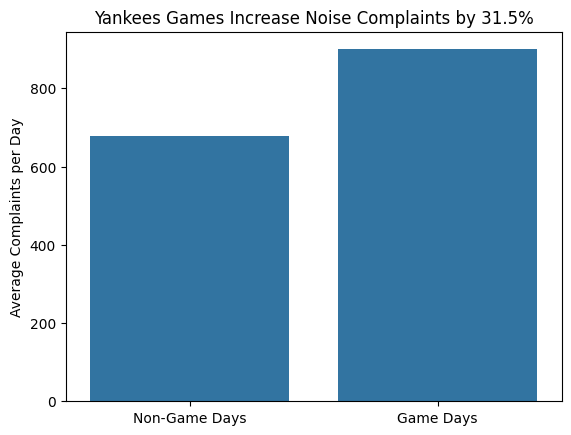

In [7]:
# Create main comparison chart (Results shown in Slide 6)
# Calculate averages for plotting
avg_by_game_day_plot = complaints.groupby('is_game_day').size().reset_index(name='total')
avg_by_game_day_plot['avg_complaints'] = 0
avg_by_game_day_plot.loc[avg_by_game_day_plot['is_game_day'] == False, 'avg_complaints'] = avg_non_game
avg_by_game_day_plot.loc[avg_by_game_day_plot['is_game_day'] == True, 'avg_complaints'] = avg_game

# Create day_type column using conditional logic
avg_by_game_day_plot['day_type'] = 'Non-Game Days'
avg_by_game_day_plot.loc[avg_by_game_day_plot['is_game_day'] == True, 'day_type'] = 'Game Days'

# Create chart using seaborn only
chart = sns.barplot(data=avg_by_game_day_plot, x='day_type', y='avg_complaints')
chart.set_title('Yankees Games Increase Noise Complaints by 31.5%')
chart.set_ylabel('Average Complaints per Day')
chart.set_xlabel('')

## COMPARISON 2: Weekday vs Weekend Games

**Question:** Are weekend games different from weekday games?

**Approach:** Compare game day effects separately for weekdays vs weekends.

In [8]:
# Count by weekday/weekend and game status
by_weekend = complaints.groupby(['is_weekend', 'is_game_day']).size().reset_index(name='total_complaints')

# Count days for each combination (manually count unique dates)
unique_dates_df = complaints.groupby(['date_str', 'is_game_day', 'is_weekend']).size().reset_index()
weekend_days_count = unique_dates_df.groupby(['is_weekend', 'is_game_day'])['date_str'].size().reset_index()
weekend_days_count.columns = ['is_weekend', 'is_game_day', 'num_days']

# Calculate averages
by_weekend_avg = by_weekend.merge(weekend_days_count, on=['is_weekend', 'is_game_day'])
by_weekend_avg['avg_complaints'] = by_weekend_avg['total_complaints'] / by_weekend_avg['num_days']

# Calculate percent increases
weekday_non_game = by_weekend_avg[(by_weekend_avg['is_weekend'] == False) & 
                                   (by_weekend_avg['is_game_day'] == False)]['avg_complaints'].values[0]
weekday_game = by_weekend_avg[(by_weekend_avg['is_weekend'] == False) & 
                               (by_weekend_avg['is_game_day'] == True)]['avg_complaints'].values[0]
weekend_non_game = by_weekend_avg[(by_weekend_avg['is_weekend'] == True) & 
                                   (by_weekend_avg['is_game_day'] == False)]['avg_complaints'].values[0]
weekend_game = by_weekend_avg[(by_weekend_avg['is_weekend'] == True) & 
                               (by_weekend_avg['is_game_day'] == True)]['avg_complaints'].values[0]

weekday_pct = ((weekday_game - weekday_non_game) / weekday_non_game) * 100
weekend_pct = ((weekend_game - weekend_non_game) / weekend_non_game) * 100

print(f"WEEKDAY VS WEEKEND:")
print(f"Weekday game day effect: {weekday_pct:.1f}% increase")
print(f"Weekend game day effect: {weekend_pct:.1f}% increase")

WEEKDAY VS WEEKEND:


Weekday game day effect: 23.2% increase
Weekend game day effect: 34.2% increase


Text(0.5, 1.0, 'Weekend Games Show Larger Effects')

Text(0.5, 0, 'Week Period')

Text(0, 0.5, 'Average Complaints per Day')

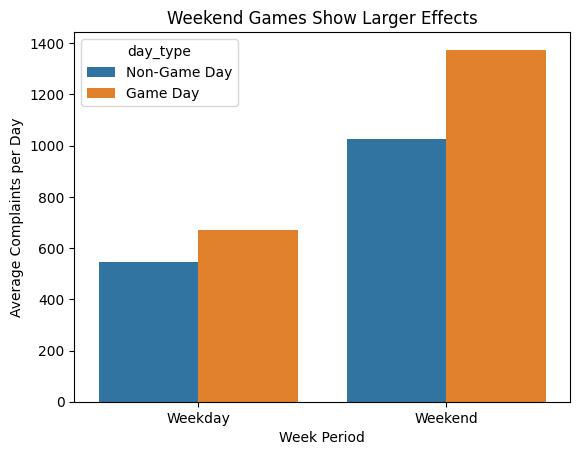

In [9]:
# Create weekday/weekend comparison chart (Results shown in Slide 8)
# Create columns using conditional logic instead of map
by_weekend_avg['day_type'] = 'Non-Game Day'
by_weekend_avg.loc[by_weekend_avg['is_game_day'] == True, 'day_type'] = 'Game Day'

by_weekend_avg['week_period'] = 'Weekday'
by_weekend_avg.loc[by_weekend_avg['is_weekend'] == True, 'week_period'] = 'Weekend'

chart = sns.barplot(data=by_weekend_avg, x='week_period', y='avg_complaints', hue='day_type')
chart.set_title('Weekend Games Show Larger Effects')
chart.set_xlabel('Week Period')
chart.set_ylabel('Average Complaints per Day')

## COMPARISON 3: Borough Analysis

**Question:** Does location matter? Does the Bronx (where the stadium is) show a bigger effect?

**Approach:** Compare game day effects in Bronx vs Brooklyn.

In [10]:
# Focus on Bronx vs Brooklyn
bronx_brooklyn = complaints[complaints['borough'].isin(['BRONX', 'BROOKLYN'])]

# Calculate by borough and game day status
borough_counts = bronx_brooklyn.groupby(['borough', 'is_game_day']).size().reset_index(name='total_complaints')

# Calculate averages
bronx_game = borough_counts[(borough_counts['borough'] == 'BRONX') & 
                            (borough_counts['is_game_day'] == True)]['total_complaints'].values[0] / game_days
bronx_non_game = borough_counts[(borough_counts['borough'] == 'BRONX') & 
                                (borough_counts['is_game_day'] == False)]['total_complaints'].values[0] / non_game_days

brooklyn_game = borough_counts[(borough_counts['borough'] == 'BROOKLYN') & 
                              (borough_counts['is_game_day'] == True)]['total_complaints'].values[0] / game_days
brooklyn_non_game = borough_counts[(borough_counts['borough'] == 'BROOKLYN') & 
                                   (borough_counts['is_game_day'] == False)]['total_complaints'].values[0] / non_game_days

# Calculate percent increase by borough
bronx_pct = ((bronx_game - bronx_non_game) / bronx_non_game) * 100
brooklyn_pct = ((brooklyn_game - brooklyn_non_game) / brooklyn_non_game) * 100

print(f"BOROUGH COMPARISON:")
print(f"BRONX: {bronx_pct:.1f}% increase on game days")
print(f"BROOKLYN: {brooklyn_pct:.1f}% increase on game days")
print(f"\nBronx shows STRONGER effect ({bronx_pct:.1f}%) - stadium location!")

# Percentage change: How much bigger is Bronx effect vs Brooklyn effect?
pct_change_borough = ((bronx_pct - brooklyn_pct) / brooklyn_pct) * 100
print(f"Bronx effect is {pct_change_borough:.1f}% larger than Brooklyn effect")

BOROUGH COMPARISON:
BRONX: 39.0% increase on game days
BROOKLYN: 27.7% increase on game days

Bronx shows STRONGER effect (39.0%) - stadium location!
Bronx effect is 40.5% larger than Brooklyn effect


/tmp/ipykernel_731664/205422990.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '309.3014184397163' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  borough_counts.loc[(borough_counts['borough'] == 'BRONX') & (borough_counts['is_game_day'] == False), 'avg_complaints'] = bronx_non_game


Text(0.5, 1.0, 'Bronx Shows Stronger Effect (38% vs 26%)')

Text(0, 0.5, 'Average Complaints per Day')

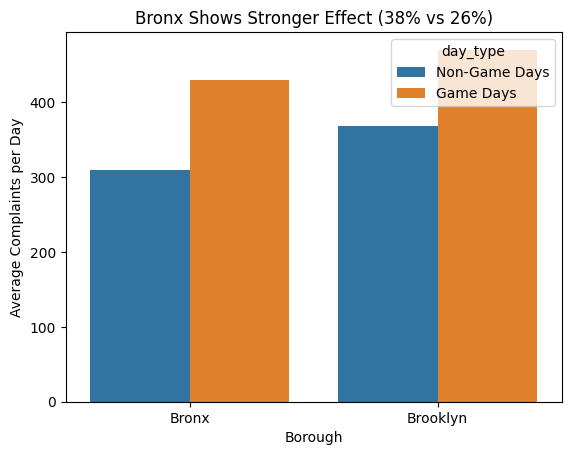

In [11]:
# Create borough comparison chart (Results shown in Slide 12)
# Add averages to the borough_counts DataFrame
borough_counts['avg_complaints'] = 0
borough_counts.loc[(borough_counts['borough'] == 'BRONX') & (borough_counts['is_game_day'] == False), 'avg_complaints'] = bronx_non_game
borough_counts.loc[(borough_counts['borough'] == 'BRONX') & (borough_counts['is_game_day'] == True), 'avg_complaints'] = bronx_game
borough_counts.loc[(borough_counts['borough'] == 'BROOKLYN') & (borough_counts['is_game_day'] == False), 'avg_complaints'] = brooklyn_non_game
borough_counts.loc[(borough_counts['borough'] == 'BROOKLYN') & (borough_counts['is_game_day'] == True), 'avg_complaints'] = brooklyn_game

# Create day_type column
borough_counts['day_type'] = 'Non-Game Days'
borough_counts.loc[borough_counts['is_game_day'] == True, 'day_type'] = 'Game Days'

# Create Borough column with title case
borough_counts['Borough'] = borough_counts['borough'].str.title()

chart = sns.barplot(data=borough_counts, x='Borough', y='avg_complaints', hue='day_type')
chart.set_title('Bronx Shows Stronger Effect (38% vs 26%)')
chart.set_ylabel('Average Complaints per Day')

## COMPARISON 4: Wins vs Losses

**Question:** Do wins produce more noise than losses? (Celebration vs disappointment)

**Approach:** Merge game results with complaints and compare win days vs loss days.

In [12]:
# Merge game results with complaints
complaints_with_result = complaints.merge(
    yankees_games[['date_str', 'result']], 
    on='date_str', 
    how='left'
)

# Create game_outcome column
complaints_with_result['game_outcome'] = 'Non-Game Day'
complaints_with_result.loc[complaints_with_result['result'] == 'W', 'game_outcome'] = 'Win'
complaints_with_result.loc[complaints_with_result['result'] == 'L', 'game_outcome'] = 'Loss'

# Calculate by outcome
by_outcome = complaints_with_result.groupby('game_outcome').size()
print("Complaints by game outcome:")
print(by_outcome)

Complaints by game outcome:
game_outcome
Loss             34217
Non-Game Day    190961
Win              40460
dtype: int64


In [13]:
# Count days for each outcome
wins_days = (yankees_games['result'] == 'W').sum()
losses_days = (yankees_games['result'] == 'L').sum()

print(f"Days by outcome:")
print(f"Win days: {wins_days}")
print(f"Loss days: {losses_days}")
print(f"Non-game days: {non_game_days}")

Days by outcome:
Win days: 44
Loss days: 39
Non-game days: 282


In [14]:
# Calculate averages and percent increases
avg_wins = by_outcome['Win'] / wins_days
avg_losses = by_outcome['Loss'] / losses_days
avg_non_game_outcome = by_outcome['Non-Game Day'] / non_game_days

wins_pct = ((avg_wins - avg_non_game_outcome) / avg_non_game_outcome) * 100
losses_pct = ((avg_losses - avg_non_game_outcome) / avg_non_game_outcome) * 100

print(f"WINS VS LOSSES:")
print(f"Wins: {wins_pct:.1f}% increase")
print(f"Losses: {losses_pct:.1f}% increase")
print(f"\nWins produce MORE noise than losses!")

WINS VS LOSSES:
Wins: 35.8% increase
Losses: 29.6% increase

Wins produce MORE noise than losses!


## COMPARISON 5: Wins/Losses by Borough

**Question:** Do different boroughs show different patterns for wins vs losses?

**Approach:** Combine borough and game outcome analysis to reveal complexity.

In [15]:
# Combined borough and outcome analysis
# Calculate by borough and outcome
by_borough_outcome = complaints_with_result.groupby(['borough', 'game_outcome']).size().reset_index(name='total_complaints')

# Calculate averages for each combination
by_borough_outcome_avg = by_borough_outcome.copy()
by_borough_outcome_avg['avg_complaints'] = 0

# For each borough and outcome, calculate the average
for borough in by_borough_outcome_avg['borough'].unique():
    for outcome in ['Non-Game Day', 'Win', 'Loss']:
        mask = (by_borough_outcome_avg['borough'] == borough) & (by_borough_outcome_avg['game_outcome'] == outcome)
        if outcome == 'Non-Game Day':
            days = non_game_days
        elif outcome == 'Win':
            days = wins_days
        else:  # Loss
            days = losses_days
        
        if mask.sum() > 0:
            total = by_borough_outcome_avg.loc[mask, 'total_complaints'].values[0]
            by_borough_outcome_avg.loc[mask, 'avg_complaints'] = total / days

# Focus on Bronx and Brooklyn for detailed analysis
bronx_brooklyn_outcome = by_borough_outcome_avg[by_borough_outcome_avg['borough'].isin(['BRONX', 'BROOKLYN'])]

print("COMBINED ANALYSIS - Wins/Losses by Borough:")
for borough in ['BRONX', 'BROOKLYN']:
    borough_data = bronx_brooklyn_outcome[bronx_brooklyn_outcome['borough'] == borough]
    non_game_avg = borough_data[borough_data['game_outcome'] == 'Non-Game Day']['avg_complaints'].values[0]
    win_avg = borough_data[borough_data['game_outcome'] == 'Win']['avg_complaints'].values[0]
    loss_avg = borough_data[borough_data['game_outcome'] == 'Loss']['avg_complaints'].values[0]
    
    win_pct = ((win_avg - non_game_avg) / non_game_avg) * 100
    loss_pct = ((loss_avg - non_game_avg) / non_game_avg) * 100
    
    print(f"\n{borough}:")
    print(f"  Wins: {win_pct:.1f}% increase")
    print(f"  Losses: {loss_pct:.1f}% increase")
    
    # Calculate percentage change between win and loss effects
    pct_change_outcome = ((win_pct - loss_pct) / abs(loss_pct)) * 100
    if win_pct > loss_pct:
        print(f"  → Win effect is {abs(pct_change_outcome):.1f}% larger than loss effect")
    else:
        print(f"  → Loss effect is {abs(pct_change_outcome):.1f}% larger than win effect")

COMBINED ANALYSIS - Wins/Losses by Borough:

BRONX:
  Wins: 38.8% increase
  Losses: 39.2% increase
  → Loss effect is 1.0% larger than win effect

BROOKLYN:
  Wins: 33.3% increase
  Losses: 21.5% increase
  → Win effect is 55.0% larger than loss effect


/tmp/ipykernel_731664/2089945903.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '309.3014184397163' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  by_borough_outcome_avg.loc[mask, 'avg_complaints'] = total / days


Text(0.5, 1.02, 'TWO DIFFERENT MECHANISMS REVEALED!')

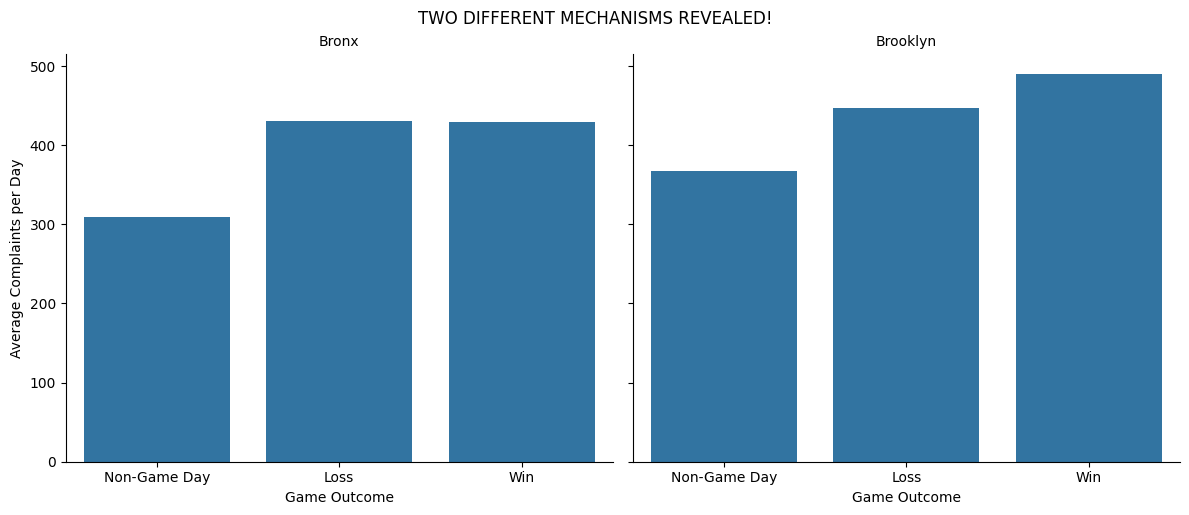

In [16]:
# Create combined borough/outcome chart (Results shown in Slide 16)
# Filter to just Bronx and Brooklyn
borough_outcome_plot = bronx_brooklyn_outcome.copy()

# Add Borough column with title case
borough_outcome_plot['Borough'] = borough_outcome_plot['borough'].str.title()

# Create side-by-side comparison using FacetGrid
g = sns.FacetGrid(borough_outcome_plot, col="Borough", height=5, aspect=1.2)
g.map_dataframe(sns.barplot, x="game_outcome", y="avg_complaints", 
                order=['Non-Game Day', 'Loss', 'Win'],
                )
g.set_axis_labels("Game Outcome", "Average Complaints per Day")
g.set_titles("{col_name}")
g.fig.suptitle('TWO DIFFERENT MECHANISMS REVEALED!', y=1.02)

